<a href="https://colab.research.google.com/github/dorianxiao/DLexp/blob/master/Exp1%3A%E6%89%8B%E5%86%99%E6%95%B0%E5%AD%97%E8%AF%86%E5%88%AB/MNIST_CNN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 导入pytorch

import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms

In [2]:
# 设置参数

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# 加载MNIST数据

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/files/', train=True, download=True,
                   transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/files/', train=False, download=True,
                   transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_test, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8139842.00it/s]                             


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 446899.27it/s]
  1%|          | 16384/1648877 [00:00<00:11, 144527.14it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 6866726.24it/s]                           
8192it [00:00, 183825.47it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [4]:
# 以测试数据为例

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# 查看一个batch的测试数据维度
example_data.shape

torch.Size([1000, 1, 28, 28])

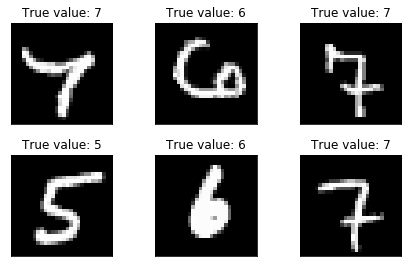

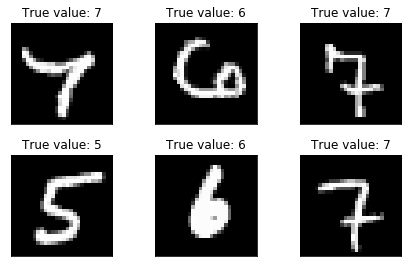

In [5]:
# 

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("True value: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
# 构建卷积网络
# 导入相关库

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# 构造网络

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 28*28*1 输入，10个5*5卷积核
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.conv2_drop = nn.Dropout2d()
        # 全连接层
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # 最大池化，采样窗口2*2，激活函数用Relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
# 初始化卷积网络

network = Net()
print(network)

optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [0]:
# 构造列表存储loss

train_losses = []
train_counter = []

test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [0]:
# 定义训练函数

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/files/model.pth')
      torch.save(optimizer.state_dict(), '/files/optimizer.pth')

In [11]:
# 开始训练

for epoch in range(1, n_epochs + 1):
  train(epoch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327588
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.278783
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.247715
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.247502
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.235826
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.215992
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.126807
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.023547
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.004896
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.928278
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.864212
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.769398
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.703963
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.739120
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.529473
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.352610
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.387650
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.407291
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.032624
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.426945
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


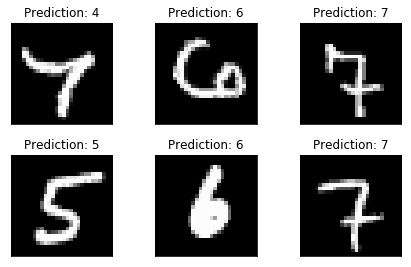

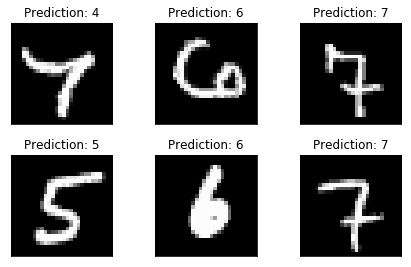

In [12]:
# 比较模型输出

with torch.no_grad():
  output = network(example_data)
  
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

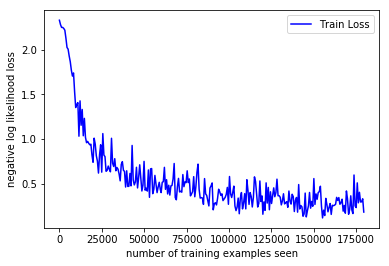

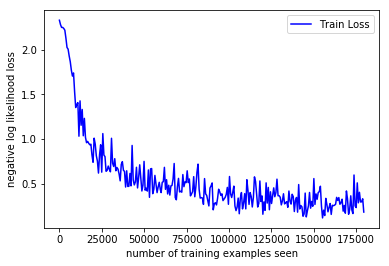

In [13]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig